## Assignment

In this assignment, you'll continue working with the [U.S. Education Dataset](https://www.kaggle.com/noriuk/us-education-datasets-unification-project/home) from Kaggle. The data gives detailed state level information on the several facets of the state of education on an annual basis. To learn more about the data and the column descriptions, you can view the Kaggle link above. You should access the data from the Thinkful database. Here's the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'<br>
postgres_pw = '7\*.8G9QH21'<br>
postgres_host = '142.93.121.174'<br>
postgres_port = '5432'<br>
postgres_db = 'useducation'<br>

Don't forget to apply the most suitable missing value filling techniques you applied in the previous checkpoint to the data. You're supposed to provide your answers to the following questions after you handled the missing values.

To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

1. Derive the descriptive statistics of the data and discuss the points you find remarkable.
2. Choose a state (e.g. California) and draw a line graph of its total revenues and total expenditures along the years. How do these 2 variables evolve during the years? Try to explain the peaks and troughs with some state-wise news and information around those dates.
3. In your chosen state, which of the lessons are the students more successful, math or reading?
4. What are the distributions of the math and reading scores in the sample?
5. Notice there are too many missing values for math and reading scores. Fill out the missing values using mean, median, and linear interpolation. Then compare the effects of these techniques on the distributions of the score variables. 

Submit your work below, and plan on discussing with your mentor. You can also take a look at these [example solutions](https://github.com/Thinkful-Ed/data-201-assignment-solutions/blob/master/model_prep_data_exploration_1/solution.ipynb).

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

edu_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [6]:
edu_df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


In [7]:
edu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G                      1

In [52]:
# Interpolate missing data
fill_list = ['ENROLL', 'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', 'TOTAL_EXPENDITURE',
            'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE',
            'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G', 'GRADES_9_12_G',
            'GRADES_ALL_G']

states = edu_df.STATE.unique()

for state in states:
    edu_df.loc[edu_df.STATE==state, fill_list] = edu_df.loc[edu_df.STATE==state, fill_list].interpolate()

edu_df.dropna(inplace=True)

In [53]:
edu_df.describe()

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
count,466.000000,4.660000e+02,4.660000e+02,4.660000e+02,4.660000e+02,4.660000e+02,4.660000e+02,4.660000e+02,4.660000e+02,4.660000e+02,...,466.00000,466.00000,466.000000,4.660000e+02,4.660000e+02,4.660000e+02,466.000000,466.000000,466.000000,466.000000
mean,2008.577253,9.442125e+05,1.078853e+07,9.568659e+05,4.999548e+06,4.832112e+06,1.086947e+07,5.638251e+06,3.181222e+06,4.913261e+05,...,72515.82618,72917.07618,64773.880901,5.836186e+05,2.867026e+05,8.933042e+05,236.909728,279.802668,219.508638,263.789943
std,5.779779,1.122051e+06,1.356335e+07,1.330702e+06,6.405481e+06,6.325995e+06,1.373667e+07,7.255903e+06,3.840941e+06,6.009649e+05,...,86463.95300,85835.16237,77557.604833,6.925615e+05,3.408161e+05,1.060080e+06,8.695903,9.381511,7.426546,6.875627
min,1996.000000,4.417900e+04,6.788740e+05,5.787000e+04,0.000000e+00,2.853100e+04,7.032450e+05,3.182600e+05,2.041170e+05,2.310700e+04,...,3423.00000,2860.00000,2188.000000,2.676200e+04,9.970000e+03,3.682300e+04,187.134670,232.831510,181.626990,236.379102
25%,2005.000000,2.794832e+05,2.712660e+06,2.614470e+05,1.491747e+06,9.513430e+05,2.670300e+06,1.416288e+06,8.472295e+05,1.296515e+05,...,20489.75000,20880.25000,18527.750000,1.666395e+05,8.194400e+04,2.596278e+05,232.760641,274.707118,215.338956,259.661771
50%,2009.000000,6.639415e+05,6.106834e+06,5.544340e+05,3.021544e+06,2.442983e+06,6.249671e+06,3.186679e+06,1.899310e+06,3.271845e+05,...,50918.00000,50114.50000,41543.000000,4.067475e+05,1.868900e+05,6.264775e+05,238.394124,281.531587,221.130461,265.217081
75%,2013.000000,1.018588e+06,1.222407e+07,1.033414e+06,6.240349e+06,5.488079e+06,1.195951e+07,6.154768e+06,3.667420e+06,5.609385e+05,...,79929.50000,80949.75000,75641.250000,6.424952e+05,3.234915e+05,9.758625e+05,242.602566,286.197041,224.531280,268.307884
max,2017.000000,6.307022e+06,8.921726e+07,9.990221e+06,5.090457e+07,3.610526e+07,8.532013e+07,4.396452e+07,2.605802e+07,3.995951e+06,...,493415.00000,500143.00000,498403.000000,3.929869e+06,2.011865e+06,5.926631e+06,253.420961,300.568235,236.773867,280.499130


In [54]:
edu_df.describe(include = "O")

,PRIMARY_KEY,STATE
count,466,466
unique,465,51
top,2009_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA
freq,2,11


In [55]:
edu_df.describe(include = "all")

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
count,466,466,466.000000,4.660000e+02,4.660000e+02,4.660000e+02,4.660000e+02,4.660000e+02,4.660000e+02,4.660000e+02,...,466.00000,466.00000,466.000000,4.660000e+02,4.660000e+02,4.660000e+02,466.000000,466.000000,466.000000,466.000000
unique,465,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2009_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2008.577253,9.442125e+05,1.078853e+07,9.568659e+05,4.999548e+06,4.832112e+06,1.086947e+07,5.638251e+06,...,72515.82618,72917.07618,64773.880901,5.836186e+05,2.867026e+05,8.933042e+05,236.909728,279.802668,219.508638,263.789943
std,NaN,NaN,5.779779,1.122051e+06,1.356335e+07,1.330702e+06,6.405481e+06,6.325995e+06,1.373667e+07,7.255903e+06,...,86463.95300,85835.16237,77557.604833,6.925615e+05,3.408161e+05,1.060080e+06,8.695903,9.381511,7.426546,6.875627
min,NaN,NaN,1996.000000,4.417900e+04,6.788740e+05,5.787000e+04,0.000000e+00,2.853100e+04,7.032450e+05,3.182600e+05,...,3423.00000,2860.00000,2188.000000,2.676200e+04,9.970000e+03,3.682300e+04,187.134670,232.831510,181.626990,236.379102
25%,NaN,NaN,2005.000000,2.794832e+05,2.712660e+06,2.614470e+05,1.491747e+06,9.513430e+05,2.670300e+06,1.416288e+06,...,20489.75000,20880.25000,18527.750000,1.666395e+05,8.194400e+04,2.596278e+05,232.760641,274.707118,215.338956,259.661771
50%,NaN,NaN,2009.000000,6.639415e+05,6.106834e+06,5.544340e+05,3.021544e+06,2.442983e+06,6.249671e+06,3.186679e+06,...,50918.00000,50114.50000,41543.000000,4.067475e+05,1.868900e+05,6.264775e+05,238.394124,281.531587,221.130461,265.217081
75%,NaN,NaN,2013.000000,1.018588e+06,1.222407e+07,1.033414e+06,6.240349e+06,5.488079e+06,1.195951e+07,6.154768e+06,...,79929.50000,80949.75000,75641.250000,6.424952e+05,3.234915e+05,9.758625e+05,242.602566,286.197041,224.531280,268.307884


We notice a couple of things:

* The average revenue is lower than the lower total expenditure. That means schools lose money on average and run on deficits.
* Instruction expenditure accounts for more than half of the total expenditure.
* Math scores are on average higher than reading scores, however, with a larger standard deviation.

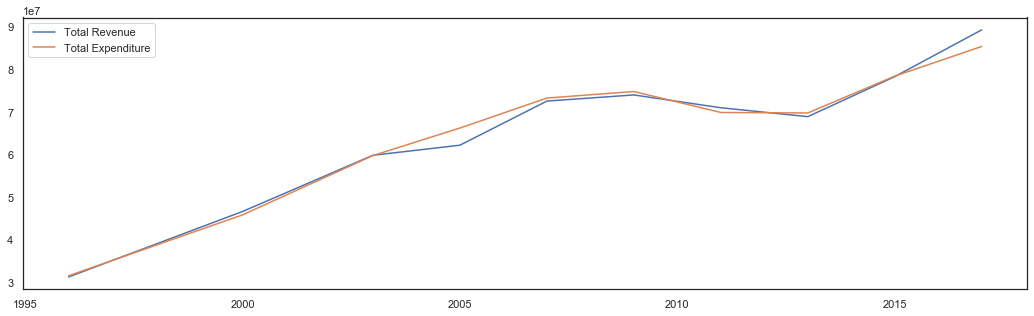

In [89]:
cali_df = edu_df[edu_df["STATE"]=="CALIFORNIA"]

plt.figure(figsize=(18,5))

plt.plot(cali_df.YEAR, cali_df.TOTAL_REVENUE, label = "Total Revenue")
plt.plot(cali_df.YEAR, cali_df.TOTAL_EXPENDITURE, label = "Total Expenditure")

plt.legend()
plt.show()

In [90]:
diff1 = pd.DataFrame(cali_df['AVG_MATH_4_SCORE'] - cali_df['AVG_READING_4_SCORE'])
diff2 = pd.DataFrame(cali_df['AVG_MATH_8_SCORE'] - cali_df['AVG_READING_8_SCORE'])
print(diff1,'\n\n', diff2)

              0
213    7.216492
420    7.648537
576   21.822545
680   23.854931
784   21.511905
891   21.912522
997   22.806357
1101  21.108497
1203  18.871396
1451  16.841127 

               0
213   -6.424972
420   -2.323040
576   11.976121
680    4.373619
784    2.222356
891   15.553342
997   11.484551
1101  15.453063
1203  16.556305
1451  14.117570


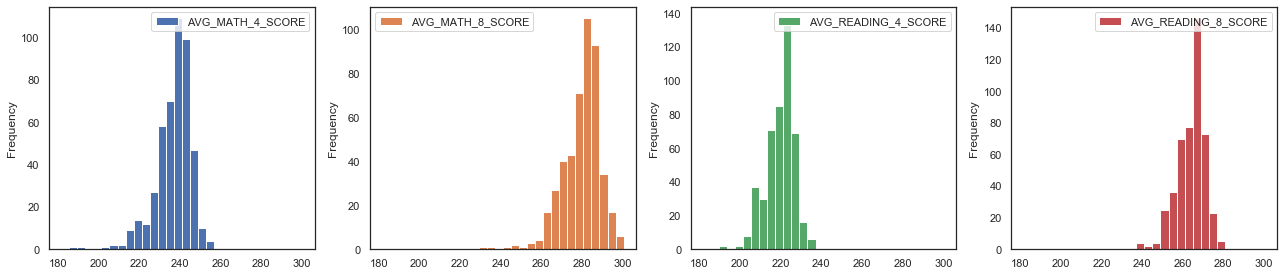

In [145]:
df = edu_df[['AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE']]
df.plot.hist(subplots=True, bins=30, layout=(1, 4), figsize=(18, 4), legend=True)
plt.tight_layout()
plt.show()

KeyError: 'AVG_MATH_4_SCORE'

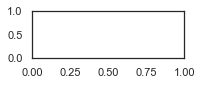

In [153]:
def impute_graphs(level):
    math_string = "AVG_MATH_"+str(level)+"_SCORE"
    reading_string = "AVG_READING_"+str(level)+"_SCORE"
    
    plt.subplot(4,2,1)
    plt.hist(edu_df.loc[math_string].dropna())
    plt.title("histogram of {} (original)".format(math_string))

    plt.subplot(4,2,2)
    plt.hist(edu_df.loc[math_string].interpolate())
    plt.title("histogram of {} (interpolated)".format(math_string))

    plt.subplot(4,2,3)
    plt.hist(edu_df.loc[math_string].fillna(education_df.loc[math_string].median()))
    plt.title("histogram of {} (filled with median)".format(math_string))

    plt.subplot(4,2,4)
    plt.hist(edu_df.loc[math_string].fillna(education_df.loc[math_string].mean()))
    plt.title("histogram of {} (filled with mean)".format(math_string))
    
    plt.subplot(4,2,5)
    plt.hist(edu_df.locreading_string.dropna())
    plt.title("histogram of {} (original)".format(reading_string))

    plt.subplot(4,2,6)
    plt.hist(edu_df.reading_string.interpolate())
    plt.title("histogram of {} (interpolated)".format(reading_string))

    plt.subplot(4,2,7)
    plt.hist(edu_df.reading_string.fillna(education_df.reading_string.median()))
    plt.title("histogram of {} (filled with median)".format(reading_string))

    plt.subplot(4,2,8)
    plt.hist(edu_df.reading_string.fillna(education_df.reading_string.mean()))
    plt.title("histogram of {} (filled with mean)".format(reading_string))

impute_graphs(4)